# ARLISS Hopes Team シミュレータ

## Import

In [1]:
import sys, traceback
import random
from functools import partial

print(sys.version)

import numpy as np
import matplotlib.pyplot as plt

import ga
import route_optimizer as rp

print("Numpy: " + np.__version__)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Numpy: 1.18.1


## 評価関数

In [17]:
def fitness_func_base(idv, weights, start, sub_goals, num_sub, distance_matrix,
                      neighbor, route_optimizer, limit_cost, limit_recalc=10, alpha=1.0):
    def calc_total_cost(route):
        total_cost = 0
        for i in range(route.shape[0]-1):
            total_cost += rp.calc_cost(route[i], route[i+1])
        return total_cost
    
    route, selected_idx = rp.generate_route(start, sub_goals, distance_matrix, target=idv)
    cost = np.inf
    eps = np.finfo(np.float32).eps
    
    if np.sum(idv) != num_sub:
        return eps
    
    for i in range(limit_recalc):
        route_opt = rp.optimize_with_2opt(neighbor, route, selected_idx, distance_matrix)
        cost = calc_total_cost(route_opt)
        if cost < limit_cost:
            break
            
    if cost > limit_cost:
        return np.maximum(eps, np.sum(weights[idv]) - alpha * np.abs(limit_cost - cost))
    else:
        return np.sum(weights[idv])

## 初期集団生成関数

- 引数
    - 個体数
    - サブゴール数
    - 評価関数
- 動作概要
    - １０点ぴったりになっている解集団をランダムに生成する
- 欠点
    - 遅い

In [30]:
def gen_initial_idvs(N_pop, N_sub, fitness_func):
    idvs = np.zeros((N_pop, N_sub), dtype=bool)
    
    while True:
        foo = np.array([np.random.choice(range(N_sub), size=num_sub, replace=False) for _ in range(2 * N_pop)])
        foo = np.unique(foo, axis=0)
        initial_idvs = np.zeros((foo.shape[0], N_sub), dtype=bool)
        tmp = np.tile(np.arange(2 * N_pop).reshape(-1, 1), num_sub)
        initial_idvs[tmp, foo] = True
        
        eps = np.finfo(np.float32).eps
        
        fitness = np.apply_along_axis(fitness_func, 1, initial_idvs)
        mask = fitness != 0
        initial_idvs = initial_idvs[mask, :].copy()
        
        null_ahed = np.where(idvs.any(axis=1) == False)[0][0]        
        idvs = np.vstack([idvs[0:null_ahed], initial_idvs])
            
        idvs_unq = np.unique(idvs, axis=0)
        idvs = np.zeros((N_pop, N_sub), dtype=bool)
        idvs[:np.minimum(N_pop, idvs_unq.shape[0]), :] = idvs_unq.copy()[:np.minimum(N_pop, idvs_unq.shape[0]), :]
                        
        if sum(idvs.any(axis=1)) >= N_pop:
            break
            
    return idvs.copy()

## シミュレーション実行

In [34]:
N_sub = 100           # サブゴール数
num_sub = 10          # 選択するサブゴールの数
neighbor = 3          # NN法を用いた経路近似解を求める際のパラメータ
limit_cost = 5.0      # 総経路長の最大値
limit_recalc = 10     # 経路最適化を再計算する最大回数

N_pop = 100     # GAの個体数
N_gen = 25      # GAの世代数
alpha = 5.0     # 制約違反量の係数

start = 2 * np.random.rand(2) - 1

sub_goals = rp.generate_points(N_sub)
weights = np.ones(N_sub)

distances = rp.generate_distance_matrix(start, sub_goals)

# 評価関数を生成
# 関数fitness_func_baseの引数idv以外を固定する
fitness_func = partial(fitness_func_base, weights=weights, start=start, distance_matrix=distances,
                       sub_goals=sub_goals, num_sub=num_sub, neighbor=neighbor,
                       route_optimizer=rp.optimize_with_2opt, limit_cost=limit_cost,
                       limit_recalc=limit_recalc, alpha=alpha)

# 初期集団生成
initial_idvs = gen_initial_idvs(N_pop, N_sub, fitness_func)

# initial_idvs = np.zeros((N_pop, N_sub), dtype=bool)
# foo = np.array([np.random.choice(range(N_sub), size=num_sub, replace=False) for _ in range(N_pop)])
# for i in range(N_pop):
#     idv = initial_idvs[i]
#     idv[foo[i]] = True
#     initial_idvs[i] = idv.copy()

genetic_algorithm = ga.GA(selection=ga.RouletteSelection(), crossover=ga.KPointCrossover(k=2),
                          mutation=ga.BitStringMutation(), m = N_sub, fitness_func=fitness_func,
                          N=N_pop, G=N_gen, idvs=initial_idvs)

In [35]:
# 最適化開始
genetic_algorithm.eval_ga()

========================= Generation 01 =========================
36; Fit: 4.64044, Idv: [False False False False False False ... False False False False False
 False]
9; Fit: 3.45103, Idv: [False False False False False False ... False False False  True False
 False]
99; Fit: 0.00000, Idv: [False False False False False False ... False False False False False
 False]
37; Fit: 0.00000, Idv: [False False False False False False ... False False False  True False
 False]
27; Fit: 0.00000, Idv: [False False False False False False ... False False False False False
 False]
========================= Generation 02 =========================
99; Fit: 0.00000, Idv: [False False False False False False ... False False False False False
 False]
36; Fit: 0.00000, Idv: [False False False False False False ... False False False  True False
 False]
26; Fit: 0.00000, Idv: [False False False False False False ... False False False False False
 False]
27; Fit: 0.00000, Idv: [False False False False False

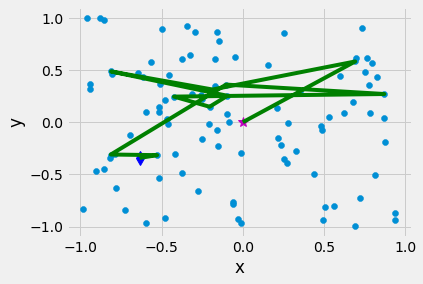

In [51]:
best_idv = genetic_algorithm.get_best_idvs()
route, idx = rp.generate_route(start, sub_goals, distances, target=best_idv)
route_opt = rp.optimize_with_2opt(neighbor, route, point_idxs=idx, distance_matrix=distances)
plt.style.use("fivethirtyeight")
rp.view_map(start, sub_goals, route_opt)

In [52]:
def calc_total_cost(route):
    total_cost = 0
    for i in range(route.shape[0]-1):
        total_cost += rp.calc_cost(route[i], route[i+1])
    return total_cost

calc_total_cost(route_opt)

7.251310656607275